# Applied Data Science Capstone Project

<h2>Webscraping information about Toronto and its Neighborhoods </h2>

Below, we will be taking (aka scraping) information from the Toronto postal codes Wikipedia webpage, using the BeautifulSoup package, and compiling it into a list of dictionaries which will include the postal codes (aka zipcodes) of the Toronto area, the boroughs within the postal codes of the Toronto area, and the neighborhoods within those boroughs. Then, we will convert the list of dictionaries into a dataframe using pandas, clean up the dataframe a little bit, and then confirming the rows and columns we have in our final dataframe.

First let's import packages that we will need to complete this process.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium

Now, let's get the link to the Toronto postal codes Wikipedia page and convert it into text.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text

Here, we will begin using BeautifulSoup to parse the html text we scraped from the web.

In [3]:
soup = BeautifulSoup(html_data, 'html.parser')

In [4]:
#separate table from html data
table = soup.find('table')

#start with an empty table, sort through the table rows, create the dictionaries and save them to the list
pc_table = []

for tr in table.find_all('td'):
    cell = {} #cell refers to the cell in the table that we will be drawing the information from where each cell has a zipcode, borough, and assosciated neighborhoods
    if tr.span.text == 'Not assigned':
        pass
    else:
        cell['Postal Code'] = tr.p.text[:3]
        cell['Borough'] = (tr.span.text).split('(')[0]
        cell['Neighborhood'] = ((((tr.span.text).split('(')[1]).replace(')', ' ')).replace(' /', ',')).strip(' ')
        pc_table.append(cell)

Now that we have completed the acquisition and organization of our data, let's put it into a dataframe for ease-of-use.

In [5]:
df = pd.DataFrame(pc_table)
df.shape #How many rows and columns do we have?

(103, 3)

In [6]:
display(df) #Display dataframe

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Oops! Looks like we have at least one issue with text running together in this dataframe. Let's fix that!

In [7]:
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade': 'Downtown Toronto Stn A',
                                       'East TorontoBusiness reply mail Processing Centre969 Eastern': 'East Toronto Business',
                                       'East YorkEast Toronto': 'East York/East Toronto',
                                       'MississaugaCanada Post Gateway Processing Centre': 'Mississauga'})

Let's take a peak at the dataframe to see if our text issues are resolved.

In [8]:
display(df)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Now let's confirm the rows and columns once more.

In [9]:
df.shape

(103, 3)

# Using Geocoder to get the Coordinates for Toronto Postal Codes

The process of getting the coordinates for the Toronto Postal Codes can be tricky, but it's a great exercise in problem-solving. First, we may run into issues of knowledge. How do we know that the coordinates are correct? The first task I would like to do is to find out what the coordinates are for the City of Toronto. This should give us a rough estimate of the coordinates we should be seeing as output from the geolocator.

In [10]:
place = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(place)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


The next step is to look at the coordinates of our different postal codes. However, if we assume that the geolocator can find the coordinates for all our data, we may find ourselves troubleshooting for coordinates it can't find, albeit repeatedly. Therefore, instead of waiting for the errors to come, let's anticipate that we may not be able to find at least one set of coordinates for whatever reason (misspellings, misreadings, etc.) and setup a <code>try</code> catch for the possibility of such an error.

In [11]:
#Getting coordinates for each zipcode using geocoder
coordinates = {}
zipcodes = list(df['Postal Code'])

for zipcode in zipcodes:
        
    geolocator = Nominatim(user_agent = 'toronto_explorer')

    location = geolocator.geocode('{}, Toronto, Ontario'.format(zipcode))
    
    try:
        latitude = location.latitude    
    except Exception:
        latitude = 'NaN'
    
    try:
        longitude = location.longitude
    except Exception:
        longitude = 'NaN'

    coordinates[zipcode] = [latitude, longitude]
coord_df = pd.DataFrame(coordinates)

As we can see, the geocoder is having some issues with reliability today. So, let's use the geospatial coordinate csv file provided.

<h3> Note: </h3> In a separate file, I will complete the above task differently instead of using the csv file provided. In real life, we will run into issues with our work and there will not be a csv file as a backup to our inability to capture or acquire the data we want, so I will develop a workaround to this issue. </h3>

In [12]:
#Read the csv file in with pandas
csv_file = pd.read_csv('/Users/charaebradshaw/IBM Data Science Professional Certificate/Geospatial_Coordinates.csv')

#Put the file into a dataframe
geo_coord = pd.DataFrame(csv_file)

#Let's view the dataframe
display(geo_coord)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


Great! We have finally gotten the coordinates into a dataframe, and they appear to be consistent with Toronto's central coordinates as well. Let's merge the coordinates with the neighborhoods and boroughs information.

In [13]:
#Merge the dataframes together on the Postal Code column
df_geo = df.merge(geo_coord, how='right', on=['Postal Code'])
df_geo.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


# Exploring the City of Toronto using Foursquare API

First, let's create a map of the City of Toronto using Folium and drop a marker at each postal code's coordinates. This will help us visualize the area.

In [14]:
# Create a map of Toronto using latitude and longitude values
toronto_map = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, long, label in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#9932CC',
        fill_opacity=1.0,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

I will need to use my Foursquare Credentials to access Foursquare's API.

In [15]:
CLIENT_ID = '1C5FNR3DHPIMLJ1Q50UATVX01G1SJVJXJUUMLYZR0ZRHETVI' # your Foursquare ID
CLIENT_SECRET = 'K2QCAXY0RCDO2WPJD2ETXJJLGRNINTLWULTELHJE54CZMEBD' # your Foursquare Secret
VERSION = '20180605' #Foursquare API version
LIMIT = 100 #A default Foursquare API limit value

<h4>How do we explore Toronto?</h4>
We will need to organize the information we collect. We will use the function <code>getNearbyVenues</code> which combines several tasks including:
<p>(1) Creating and executing an API request <p>
<p>(2) Searching for venues based on latitude and longitude<p>
<p>(3) Sorting the nearby venues by category

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, long in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues) #returns a dataframe of venues near each neighborhood

# Exploring Neighborhoods in Toronto

In [17]:
toronto_venues = getNearbyVenues(names=df_geo['Neighborhood'],
                                latitudes=df_geo['Latitude'],
                                longitudes=df_geo['Longitude']
                                )

Let's explore the <code>toronto_venues</code> dataframe.

In [18]:
toronto_venues.shape

(2118, 7)

In [19]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    freq = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    freq.columns = ['venue','freq']
    freq = freq.iloc[1:]
    freq['freq'] = freq['freq'].astype(float)
    freq = freq.round({'freq': 2})
    print(freq.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3         Chinese Restaurant  0.25
4                     Market  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2  Sandwich Place  0.14
3             Pub  0.14
4    Dance Studio  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0                Bank  0.08
1         Coffee Shop  0.08
2  Frozen Yogurt Shop  0.04
3         Gas Station  0.04
4         Bridal Shop  0.04


----Bayview Village----
                        venue  freq
0          Chinese Restaurant  0.25
1                        Café  0.25
2                        Bank  0.25
3         Japanese Restaurant  0.25
4  Modern European Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.08

4                   Dog Run   0.2


----Humber Summit----
                      venue  freq
0                       Gym   0.5
1              Intersection   0.5
2               Yoga Studio   0.0
3  Mediterranean Restaurant   0.0
4        Miscellaneous Shop   0.0


----Humberlea, Emery----
            venue  freq
0     Fabric Shop   0.5
1  Baseball Field   0.5
2  Lingerie Store   0.0
3    Liquor Store   0.0
4          Lounge   0.0


----Humewood-Cedarvale----
          venue  freq
0         Field  0.25
1        Garden  0.25
2  Hockey Arena  0.25
3         Trail  0.25
4   Yoga Studio  0.00


----India Bazaar, The Beaches West----
                  venue  freq
0                  Park  0.11
1  Fast Food Restaurant  0.11
2                   Gym  0.06
3                   Pub  0.06
4               Brewery  0.06


----Kennedy Park, Ionview, East Birchmount Park----
                venue  freq
0  Chinese Restaurant  0.25
1         Coffee Shop  0.25
2          Hobby Shop  0.25
3    Department Sto

4  Opera House  0.00


----Thorncliffe Park----
               venue  freq
0  Indian Restaurant  0.10
1        Yoga Studio  0.05
2               Park  0.05
3       Burger Joint  0.05
4           Bus Line  0.05


----Toronto Dominion Centre, Design Exchange----
                venue  freq
0         Coffee Shop  0.11
1               Hotel  0.08
2                Café  0.06
3         Salad Place  0.03
4  Seafood Restaurant  0.03


----University of Toronto, Harbord----
                 venue  freq
0                 Café  0.16
1            Bookstore  0.06
2               Bakery  0.06
3                  Bar  0.06
4  Japanese Restaurant  0.06


----Victoria Village----
                   venue  freq
0  Portuguese Restaurant  0.17
1           Hockey Arena  0.17
2           Intersection  0.17
3            Coffee Shop  0.17
4            Pizza Place  0.17


----West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale----
                       venue  freq
0                     Baker

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Chinese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Dance Studio,Gym,Pub,Sandwich Place,Dim Sum Restaurant,Deli / Bodega,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Mobile Phone Shop,Diner,Sandwich Place,Bridal Shop,Intersection,Deli / Bodega,Restaurant,Ice Cream Shop
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Restaurant,Thai Restaurant,Liquor Store,Indian Restaurant,Pub,Fast Food Restaurant,Butcher


# Clustering Neighborhoods

What is the optimal number of clusters? Let's use the Within Cluster Sum of Squared Errors (WSS) for different values of k.

In [25]:
def calculate_WSS(points, max_k):
  sse = []
  for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse

In [26]:
#Gather corresponding venue latitudes and venue longitudes together
n_lats = list(toronto_venues['Neighborhood Latitude'])
n_longs = list(toronto_venues['Neighborhood Longitude'])
points = np.zeros((len(n_lats), 2))
for j in range(len(n_lats)):
    points[j, 0] = n_lats[j]
    points[j, 1] = n_longs[j]

In [27]:
WSS = calculate_WSS(points, 10)
print(WSS)

[9.869014044247022, 6.392544739299543, 3.482994373231543, 2.5609851245151036, 2.084820111234701, 1.7364729694856496, 1.4058004356888791, 1.214480934602752, 1.0379392235736846, 0.9309647299767151]


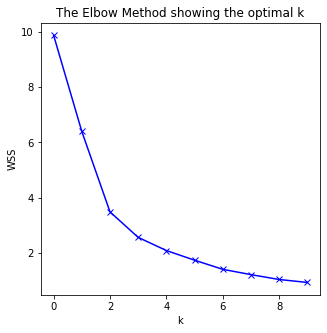

In [28]:
#Elbow Method Graph
K = range(0,10)
plt.figure(figsize=(5,5))
plt.plot(K, WSS, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Looks like clustering would be best around k = 3. Let's try that.

In [29]:
#Set number of clusters
k = 3

#Drop Neighborhood Column
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', axis=1)

#Run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(toronto_grouped_clustering)

#Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [30]:
#Add clustering labels to dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_geo

#Merge toronto_grouped with df_geo to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Fast Food Restaurant,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Coffee Shop,Hockey Arena,Pizza Place,Financial or Legal Service,Intersection,Women's Store,Deli / Bodega,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Breakfast Spot,Theater,Café,Pub,Farmers Market,Bank,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Accessories Store,Coffee Shop,Vietnamese Restaurant,Boutique,Carpet Store,Discount Store,Deli / Bodega
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Sandwich Place,Bar,Beer Bar,Smoothie Shop,College Auditorium,Japanese Restaurant,Distribution Center


In [31]:
for (col, col_data) in toronto_merged.iteritems():
    print("NaN values in ", col, ": ", toronto_merged[col].isnull().sum())

NaN values in  Postal Code :  0
NaN values in  Borough :  0
NaN values in  Neighborhood :  0
NaN values in  Latitude :  0
NaN values in  Longitude :  0
NaN values in  Cluster Labels :  3
NaN values in  1st Most Common Venue :  3
NaN values in  2nd Most Common Venue :  3
NaN values in  3rd Most Common Venue :  3
NaN values in  4th Most Common Venue :  3
NaN values in  5th Most Common Venue :  3
NaN values in  6th Most Common Venue :  3
NaN values in  7th Most Common Venue :  3
NaN values in  8th Most Common Venue :  3
NaN values in  9th Most Common Venue :  3
NaN values in  10th Most Common Venue :  3


In [32]:
toronto_merged.loc[(toronto_merged['Cluster Labels'].isnull())]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's drop these rows since they have a lack of values when it comes to the most common venues and therefore are not assigned to a cluster.

In [33]:
toronto_merged.drop([5, 45, 95], axis=0, inplace=True)

In [34]:
for (col, col_data) in toronto_merged.iteritems():
    print("NaN values in ", col, ": ", toronto_merged[col].isnull().sum())

NaN values in  Postal Code :  0
NaN values in  Borough :  0
NaN values in  Neighborhood :  0
NaN values in  Latitude :  0
NaN values in  Longitude :  0
NaN values in  Cluster Labels :  0
NaN values in  1st Most Common Venue :  0
NaN values in  2nd Most Common Venue :  0
NaN values in  3rd Most Common Venue :  0
NaN values in  4th Most Common Venue :  0
NaN values in  5th Most Common Venue :  0
NaN values in  6th Most Common Venue :  0
NaN values in  7th Most Common Venue :  0
NaN values in  8th Most Common Venue :  0
NaN values in  9th Most Common Venue :  0
NaN values in  10th Most Common Venue :  0


<h2>Map of Clusters</h2>

Now we can map the venues and examine the clusters!

In [35]:
centroids = kmeans.cluster_centers_
clat = []
clong = []
for center in centroids:
    clat.append(center[0])
    clong.append(center[1])

In [36]:
#Acquire all labels
cluster_labels = toronto_merged['Cluster Labels'].unique()

In [37]:
#Create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    try:
        cluster = int(cluster)
        
    except Exception:
        pass
        
    label = folium.Popup(str(poi) + ', ' + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
        
for clat_, clong_, cluster_label in zip(clat, clong, cluster_labels):
        clabel = folium.Popup('Centroid ' + str(cluster_label), parse_html=True)
        folium.CircleMarker(
            [clat_, clong_],
            radius=5,
            popup=clabel,
            color='black',
            fill=True,
            fill_color='#FFFF00',
            fill_opacity=1.0,
            parse_html=False).add_to(map_clusters)
       
map_clusters

# Examining Clusters

Let's see what venues are in each cluster.

<h2>Cluster 0</h2>

In [38]:
Cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
Cluster_0

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Fast Food Restaurant,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Coffee Shop,Hockey Arena,Pizza Place,Financial or Legal Service,Intersection,Women's Store,Deli / Bodega,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Breakfast Spot,Theater,Café,Pub,Farmers Market,Bank,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Accessories Store,Coffee Shop,Vietnamese Restaurant,Boutique,Carpet Store,Discount Store,Deli / Bodega
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Sandwich Place,Bar,Beer Bar,Smoothie Shop,College Auditorium,Japanese Restaurant,Distribution Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.0,Coffee Shop,Café,Hotel,Gym,Restaurant,Japanese Restaurant,Deli / Bodega,Seafood Restaurant,Salad Place,Steakhouse
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0.0,Pool,Park,Smoke Shop,River,Women's Store,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Mediterranean Restaurant,Men's Store,Hotel,Yoga Studio,Pub
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,0.0,Light Rail Station,Auto Workshop,Brewery,Burrito Place,Skate Park,Fast Food Restaurant,Farmers Market,Pizza Place,Spa,Comic Shop


<h2>Cluster 1</h2>

In [39]:
Cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
Cluster_1

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,1.0,Park,Pool,Women's Store,Adult Boutique,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
35,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,1.0,Park,Convenience Store,Pizza Place,Coffee Shop,General Entertainment,Gay Bar,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
52,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,1.0,Park,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
64,M9N,York,Weston,43.706876,-79.518188,1.0,Park,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
66,M2P,North York,York Mills West,43.752758,-79.400049,1.0,Park,Convenience Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Curling Ice
91,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1.0,Park,Playground,Trail,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


<h2>Cluster 2</h2>

Cluster 2 is a much larger and more dense cluster with 84 neighborhoods. We will need to break this down.

In [40]:
Cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
Cluster_2

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,2.0,Fabric Shop,Baseball Field,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,2.0,Baseball Field,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


<h2>Comparing Clusters</h2>

The above three clusters should be grouped as follows:
<p>
    * A very large cluster with neighborhoods that have at least one restaurant in their top tens most common venues<p>
        * A very small cluster with neighborhoods that have very similar top ten most common venues (at least nine venues in common, but not necessarily in the same rank)<p>
            * A third cluster that encompasses neighborhoods that have a park as the 1st or 2nd Most Common Venue.